# Notebook 3-2: Static AEC Analysis

In this notebook, we will cover:
1. Loading data.
2. Calculating static Amplitude Envelope Correlation (AEC) networks.
3. Plotting AEC networks.

## 1. Loading data

First, we load the source reconstructed (parcel) data.

In [1]:
from glob import glob
from osl_dynamics.data import Data

files = sorted(glob("wakeman-henson/*/*_sflip_lcmv-parc-raw.fif"))
data = Data(files, picks="misc", reject_by_annotation="omit")
print(data)

Loading files:   0%|          | 0/5 [00:00<?, ?it/s]

Data
 id: 5596070832
 n_sessions: 5
 n_samples: 599252
 n_channels: 38


We have 5 session that were generated with the 'Giles' (`fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz`) parcellation.

## 2. Calculating AEC networks

We will estimate static AEC networks for each session. AEC can be calculated from the parcellated time series directly. First, we need to prepare the parcellated data. Previously we loaded the data using the [Data class](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/data/base/index.html#osl_dynamics.data.base.Data). Fortunately, the `Data` class has a `prepare` method that makes this easy. Let's prepare the data for calculate the AEC network for activity in the alpha band (8-12 Hz).

In [2]:
# Before we can prepare the data we must specify the sampling frequency
# (this is needed to bandpass filter the data)
data.set_sampling_frequency(250)

# Calculate amplitude envelope data for the alpha band (7-13 Hz)
methods = {
    "standardize": {},
    "filter": {"low_freq": 7, "high_freq": 13},
    "amplitude_envelope": {},
}
data.prepare(methods)

# Get the amplitude envelope time series for each subject (ts is a list of numpy arrays)
ts = data.time_series()

Standardize:   0%|          | 0/5 [00:00<?, ?it/s]

Filtering:   0%|          | 0/5 [00:00<?, ?it/s]

Amplitude envelope:   0%|          | 0/5 [00:00<?, ?it/s]

Other common frequency bands are:
- Delta: 1-4 Hz.
- Theta: 4-7 Hz.
- Beta: 13-30 Hz.
- Gamma: 30+ Hz.

Next, we want to calculate the correlation between amplitude envelopes. osl-dynamics has the [analysis.static.functional_connectivity ](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/analysis/static/index.html#osl_dynamics.analysis.static.functional_connectivity) function for this.

In [3]:
from osl_dynamics.analysis import static

aec = static.functional_connectivity(ts)
print(aec.shape)

(5, 38, 38)


## 3. Plotting AEC Networks

A common approach for plotting a network is as a matrix. We can do this with the [plotting.plot_matrices](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/utils/plotting/index.html#osl_dynamics.utils.plotting.plot_matrices) function in osl-dynamics.

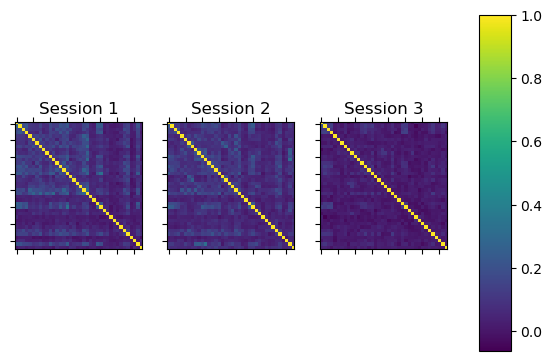

In [4]:
import numpy as np
from osl_dynamics.utils import plotting

# zero the diagonal so we can see the off-diagonal values better
mat = np.copy(aec)  # we don't want to change the original aec array
for m in mat:
    np.fill_diagonal(m, 0)

# Just plot the first 3
fig, ax = plotting.plot_matrices(aec[:3], titles=[f"Session {i+1}" for i in range(3)])

Another way we can visualise the network is a glass brain plot. We can do this using the [connectivity.save](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/analysis/connectivity/index.html#osl_dynamics.analysis.connectivity.save) function in osl-dynamics. This function is a wrapper for the nilearn function [plot_connectome](https://nilearn.github.io/stable/modules/generated/nilearn.plotting.plot_connectome.html). Let's use [connectivity.save](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/analysis/connectivity/index.html#osl_dynamics.analysis.connectivity.save) to plot the first session's AEC network.

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

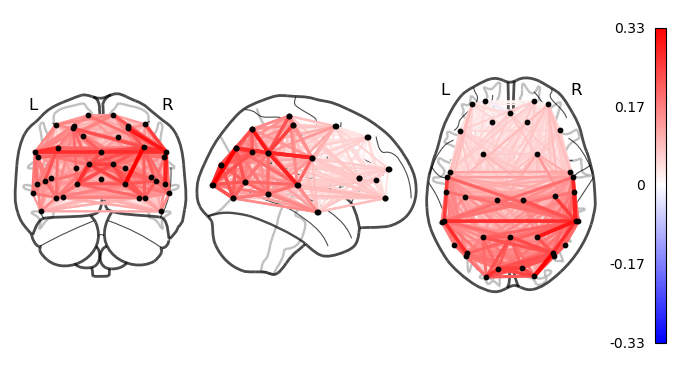

In [5]:
from osl_dynamics.analysis import connectivity

connectivity.save(
    aec[0],
    parcellation_file="fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz",
)

In the above plot we see every pairwise connection. Often, we're just interested in the strongest connections - this helps us to avoid interpreting connections that are simply due to noise. Next, let's see how we threshold the networks.

### Thresholding networks

We can use the [connectivity.threshold](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/analysis/connectivity/index.html#osl_dynamics.analysis.connectivity.threshold) function in osl-dynamics to select the strongest connections. The easiest way to threshold is to pass the `percentile` argument, let's select the top 5% of connections.

Saving images:   0%|          | 0/3 [00:00<?, ?it/s]

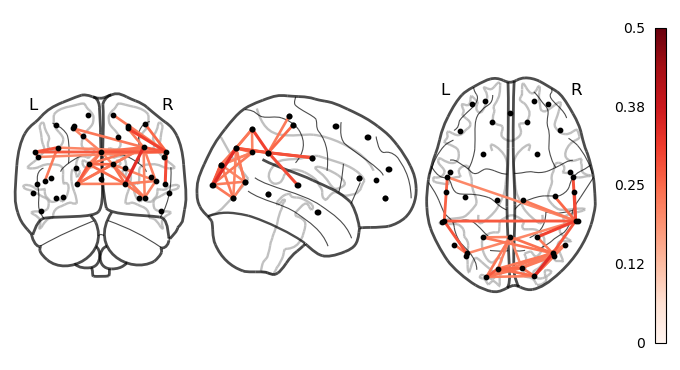

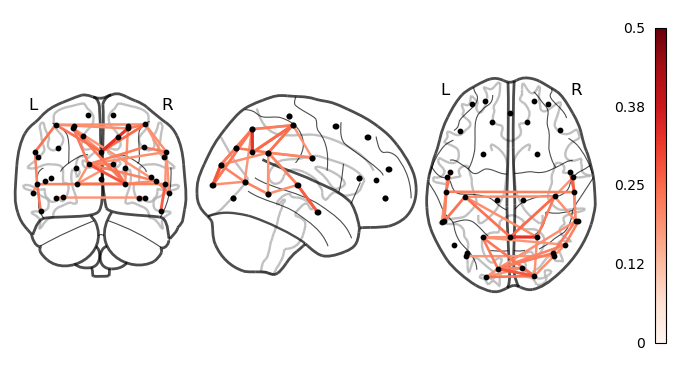

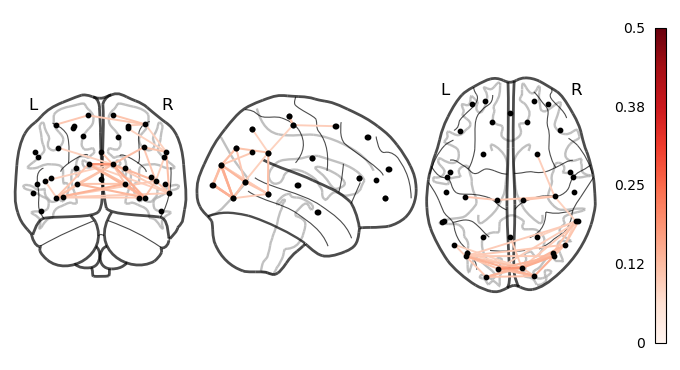

In [6]:
thres_aec = connectivity.threshold(aec, percentile=95)

connectivity.save(
    thres_aec[:3],
    parcellation_file="fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz",
    plot_kwargs={"edge_vmin": 0, "edge_vmax": 0.5, "edge_cmap": "Reds"},
)

Estimating subject-specific connectivity networks is often very noisy. Cleaner networks come out when we average over groups as this removes noise. Let's plot the group average AEC network.

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

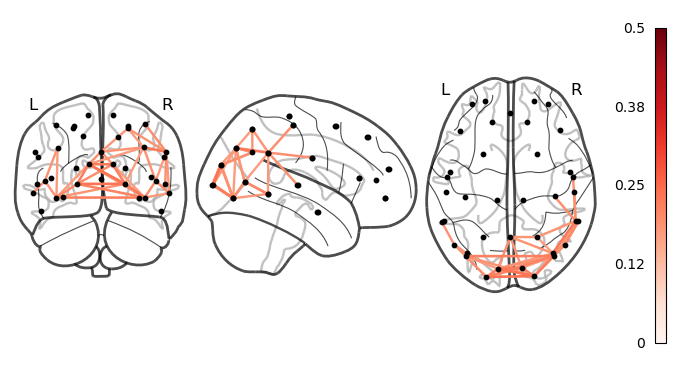

In [7]:
# Average over the group
group_aec = np.mean(aec, axis=0)

# Keep the top 5% of connections
thres_group_aec = connectivity.threshold(group_aec, percentile=95)

# Plot
connectivity.save(
    thres_group_aec,
    parcellation_file="fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz",
    plot_kwargs={"edge_vmin": 0, "edge_vmax": 0.5, "edge_cmap": "Reds"},
)

Note: it's possible to make 3D interactive plots with osl-dynamics:

In [8]:
connectivity.save_interactive(
    thres_group_aec,
    parcellation_file="fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz",
)

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

For further options for how to threshold the the networks see the [tutorial](https://osl-dynamics.readthedocs.io/en/latest/tutorials_build/static_aec_analysis.html) in the documentation.